# Fuel Efficiency Prediction (Auto MPG Dataset)

**Objective:**

The goal of this project is to build and evaluate regression models that predict vehicle fuel efficiency (miles per gallon) using engine characteristics and design features from the Auto MPG dataset. The project emphasizes proper data preprocessing, feature engineering, model evaluation, and interpretability, reflecting a real world regression workflow.

# **Importation of Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# **Data Exploration**

Initial exploration showed that the dataset contains a mix of numerical and categorical variables describing vehicle characteristics such as engine size, weight, and model year. The target variable, miles per gallon (mpg), shows meaningful variation across vehicles.

A data quality issue was identified in the `horsepower` column, which was stored as an object type due to the presence of missing values represented by `"?"`.

### Data Source
The Auto MPG dataset was loaded from a CSV file located in the same directory as this notebook to ensure reproducibility


In [ ]:
df = pd.read_csv("auto-mpg.csv")

In [ ]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [ ]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


# **Data Cleaning**

The `horsepower` column contained missing values encoded as `"?"`. These values were converted to NaN and removed. Since the proportion of missing observations was small relative to the dataset size, dropping these rows was unlikely to bias the results.

All remaining features were converted to appropriate numeric data types.

The `car name` variable was excluded from modeling because it is a high-cardinality identifier and does not provide meaningful numerical information for regression.

The `origin` variable had already been encoded earlier in the preprocessing stage.  
Therefore, no further categorical transformation was required at this step.

In [ ]:
#If a column is supposed to be numeric but pandas detected it as object:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"--- {col} ---")
        non_numeric = df[col][~df[col].str.replace('.', '', 1).str.isnumeric()]
        print(non_numeric.unique())

--- horsepower ---
['?']
--- car name ---
['chevrolet chevelle malibu' 'buick skylark 320' 'plymouth satellite'
 'amc rebel sst' 'ford torino' 'ford galaxie 500' 'chevrolet impala'
 'plymouth fury iii' 'pontiac catalina' 'amc ambassador dpl'
 'dodge challenger se' "plymouth 'cuda 340" 'chevrolet monte carlo'
 'buick estate wagon (sw)' 'toyota corona mark ii' 'plymouth duster'
 'amc hornet' 'ford maverick' 'datsun pl510'
 'volkswagen 1131 deluxe sedan' 'peugeot 504' 'audi 100 ls' 'saab 99e'
 'bmw 2002' 'amc gremlin' 'ford f250' 'chevy c20' 'dodge d200' 'hi 1200d'
 'chevrolet vega 2300' 'toyota corona' 'ford pinto'
 'plymouth satellite custom' 'ford torino 500' 'amc matador'
 'pontiac catalina brougham' 'dodge monaco (sw)'
 'ford country squire (sw)' 'pontiac safari (sw)'
 'amc hornet sportabout (sw)' 'chevrolet vega (sw)' 'pontiac firebird'
 'ford mustang' 'mercury capri 2000' 'opel 1900' 'peugeot 304' 'fiat 124b'
 'toyota corolla 1200' 'datsun 1200' 'volkswagen model 111'
 'plymouth cr

In [ ]:
df['horsepower'] = df['horsepower'].replace('?', np.nan) #Replacing ? with NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [ ]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [ ]:
missing_percentage = (df.isnull().sum()/len(df))*100
missing_percentage

mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      1.507538
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
car name        0.000000
dtype: float64

In [ ]:
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


# **Feature Engineering**


Two additional features were engineered to capture interaction-like effects between engine characteristics:

- **Power-to-weight ratio**: horsepower divided by vehicle weight  
- **Engine size per cylinder**: displacement divided by number of cylinders  

These engineered features were added alongside the original predictors to preserve existing signal while enhancing model clarity.


In [ ]:
df_new = df.copy()

In [ ]:
df_new['power_to_weight'] = df_new['horsepower'] / df_new['weight']

In [ ]:
df_new['engine_size'] = df_new['displacement'] / df_new['cylinders']

In [ ]:
df_new.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,power_to_weight,engine_size
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0.037100,38.375
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0.044679,43.750
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0.043655,39.750
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0.043694,38.000
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0.040591,37.750


# **Baseline Model & Evaluation**


A multiple linear regression model was used as the baseline to predict vehicle fuel efficiency (MPG).  
This model provides a strong, interpretable starting point and allows for diagnostic checks of linear model assumptios
Feature scaling was applied only to the input variables (`X`) using the training set statistics. The target variable (`mpg`) was left unscaled.
Scaling was necessary for coefficient interpretation and for regularized models such as Ridge regression. The scaler was fit on the training data and applied consistently to the test data to avoid data leakage.

In [ ]:
X = df_new.drop(['mpg', 'car name'], axis=1)
y = df_new['mpg']  # Target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
MAE = mean_absolute_error(y_test, y_pred_test)
print(round(MAE,2))

2.25


In [ ]:
average_mpg = df['mpg'].mean()
MAE_percentage_of_avg = (MAE / average_mpg) * 100

print(round(MAE_percentage_of_avg, 2))

9.62


In [ ]:
# Calculate R-squared for the test set
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(round(r2_train,2))
print(round(r2_test, 2))

0.86
0.82


Model performance was evaluated using:
- **R² (Coefficient of Determination)** to measure explained variance
- **Mean Absolute Error (MAE)** expressed as a percentage for interpretability

Both training and test performance were reported to assess generalization.

In [ ]:
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

standardized_coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Standardized Coefficient': lr_scaled.coef_
})

standardized_coeffs['Abs_Coeff'] = standardized_coeffs['Standardized Coefficient'].abs()

standardized_coeffs = standardized_coeffs.sort_values('Abs_Coeff', ascending=False)

# Intercept
intercept = lr_scaled.intercept_

display(standardized_coeffs)
print(f"Intercept: {intercept}")

,Feature,Standardized Coefficient,Abs_Coeff
1,displacement,12.771906,12.771906
0,cylinders,-7.679607,7.679607
3,weight,-7.028574,7.028574
8,engine_size,-6.673239,6.673239
2,horsepower,3.091669,3.091669
5,model year,2.803203,2.803203
7,power_to_weight,-2.685770,2.685770
6,origin,0.534142,0.534142
4,acceleration,-0.417772,0.417772


Intercept: 23.599361022364228


# **Residual Analysis**

Residual diagnostics were performed to validate linear regression assumptions.

- Residuals were randomly scattered around zero
- No clear curvature was observed
- The variance of residuals appeared approximately constant
- The residual distribution was roughly symmetric

These patterns support the suitability of a linear modeling approach for this dataset.

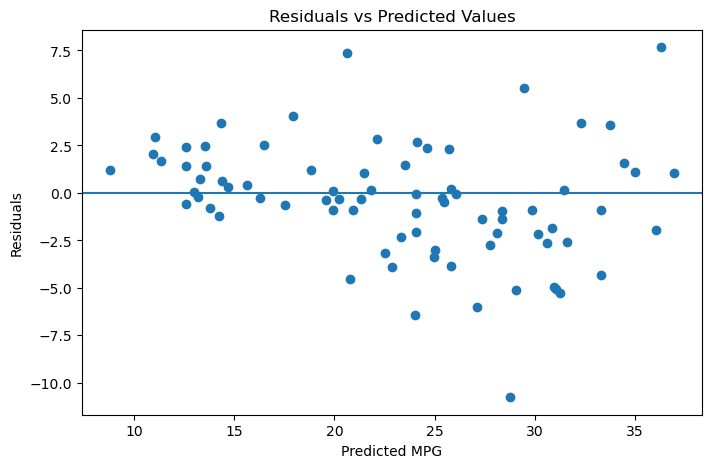

In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, residuals)
plt.axhline(0)
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

The residuals appear randomly scattered around zero, suggesting that the linearity and homoscedasticity assumptions are reasonably satisfied.

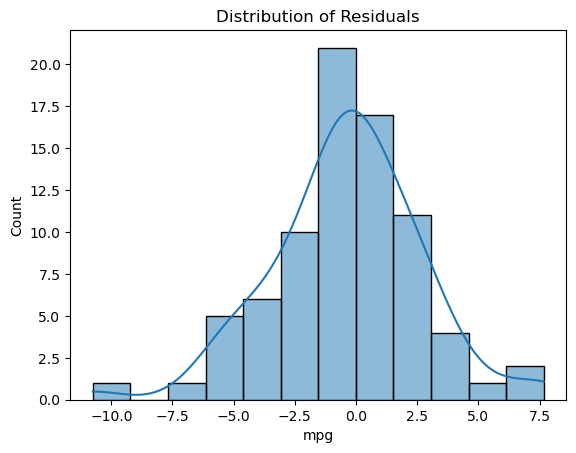

In [ ]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

The residuals are approximately symmetric and centered around zero, indicating that the normality assumption is reasonably satisfied.


# **Multicollinearity Check**

Variance Inflation Factor (VIF) was computed to assess multicollinearity among predictors. Some degree of correlation was observed between engine-related variables.

While multicollinearity does not affect predictive accuracy, it can inflate coefficient variance. This motivated the comparison with Ridge regression, which is more robust in the presence of correlated predicto.

An intercept term was added explicitly for VIF computation using statmodels; scikit-learn models include the intercept by default.

In [ ]:
X_vif = X_train.copy()
X_vif = sm.add_constant(X_vif)

In [ ]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]
vif_data

,Feature,VIF
0,const,2018.787047
1,cylinders,53.724816
2,displacement,137.743708
3,horsepower,95.903296
4,weight,61.184121
5,acceleration,2.952510
6,model year,1.322975
7,origin,2.194465
8,power_to_weight,25.976840
9,engine_size,34.627721


Variance Inflation Factor (VIF) was computed as a diagnostic step using the training data only.  
This analysis was performed independently of the modeling pipeline and did not alter the feature matrix used for model fitting or cross-validation.

# **Ridge Regression Comparison**

Ridge regression was evaluated as a regularized alternative to ordinary least squares regression. By penalizing large coefficients, Ridge regression reduces model variance and improves stability when predictors are correlated.

The Ridge model achieved slightly lower MAE and comparable R² relative to the linear regression model, indicating improved generalization

In [ ]:
# Train
ridge = Ridge(alpha=1.0, random_state=42)  # start simple
ridge.fit(X_train, y_train)

# Predict
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred_ridge))
print("Test R²:", r2_score(y_test, y_test_pred_ridge))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_ridge))

Train R²: 0.8561806382130686
Test R²: 0.8164791301543339
Test MAE: 2.238538747406413


In [ ]:
MAE_percentage_of_avg2 = ( mean_absolute_error(y_test, y_test_pred_ridge) / average_mpg) * 100

print(round(MAE_percentage_of_avg2, 2))

9.55


# **Cross Validation**


A 5-fold cross-validation strategy was used to assess the stability of the model across different data splits.

Cross-validation results showed moderate variance across folds, providing a realistic estimate of average model performance and confirming that the model generalizes reasonably well beyond a single train–test spit.


In [ ]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

In [ ]:
cv_mae = cross_val_score(
    pipeline,
    X, y,
    cv=5,
    scoring="neg_mean_absolute_error"
)

cv_mae = -cv_mae

In [ ]:
print("CV MAE scores:", cv_mae)
print("Mean MAE:", cv_mae.mean())
print("Std MAE:", cv_mae.std())

CV MAE scores: [3.29087397 2.05435518 1.79799667 2.68755841 3.77965528]
Mean MAE: 2.7220879015751067
Std MAE: 0.7406713482824704


In [ ]:
cv_r2 = cross_val_score(
    pipeline,
    X, y,
    cv=5,
    scoring="r2"
)

print("Mean R²:", cv_r2.mean())
print("Std R²:", cv_r2.std())

Mean R²: 0.6523302104912013
Std R²: 0.1929570346123913


In [ ]:
MAE_percentage_of_avg3 = (cv_mae.mean() / average_mpg) * 100

print(round(MAE_percentage_of_avg3, 2))

11.61


# **Final Model Selection**

Based on test-set performance, cross-validation results, residual diagnostics, and model stability, Ridge regression was selected as the final model.

Although performance differences between linear and Ridge regression were modest, Ridge regression provides better robustness in the presence of correlated predictors, which is common in real-world datasets.

# **Conclusion**

This project demonstrated a complete regression workflow, including data cleaning, feature engineering, model evaluation, diagnostic checks, and regularization. Ridge regression was selected as the final model due to its stability and generalization performance.

The approach reflects best practices for real-world regression problems, balancing predictive accuracy, interpretability, and robustnes.
